In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [46]:
data_folder = 'C:/Users/A/Desktop/Training_data_128/customData_anse'
parameters_file = data_folder + '/0_Data.txt'

#calculate for normalize(mean,std)
def load_and_combine_data(data_folder):
    file_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('9.txt')]
    all_data = []

    for file_path in file_paths:
        #Loading arrary data from each txt file
        data = np.loadtxt(file_path)
        all_data.append(data)

    #combine all data to one file
    combined_data = np.concatenate(all_data, axis=0)
    return combined_data

def calculate_statistics(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std

combined_data = load_and_combine_data(data_folder)
mean, std = calculate_statistics(combined_data)

In [47]:
#check the mean and std 
print(mean,std)

-0.029182019126922178 0.11373121119680919


In [48]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, parameters_file, mean, std):
        self.data_folder = data_folder
        self.parameters = self.read_parameters(parameters_file)
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            transforms.Normalize(mean, std)
        ])
        self.data_numbers = [data_num for data_num in self.parameters.keys() if data_num.endswith('9')]

#Read '0_Data.txt'
    def read_parameters(self, file_path):
        parameters = {}
        with open(file_path, 'r') as file:
            for index, line in enumerate(file):
                if index == 0:  # Skip 1st row
                    continue
                parts = line.strip().split(',')
                data_number = parts[0]
                params = np.array(parts[1:4], dtype=np.float32)
                parameters[data_number] = params
        return parameters

    def __len__(self):
        return len(self.data_numbers)

    def __getitem__(self, idx):
        data_number = self.data_numbers[idx]
        matrix_path = os.path.join(self.data_folder, f'{data_number}.txt')
        matrix = np.loadtxt(matrix_path)  # Load matrix from a txt file
        matrix = torch.from_numpy(matrix).float().unsqueeze(0)  # 2D -> 3D tensor
        matrix = self.transform(matrix)
        params = self.parameters[data_number]
        return matrix, params

custom_dataset = CustomDataset(data_folder=data_folder, parameters_file=parameters_file, mean=mean, std=std)

In [49]:
#check the custom_dataset
print(custom_dataset[0])

(tensor([[[-3.5984, -3.5984, -3.5983,  ...,  0.2767,  0.2770,  0.2772],
         [-3.5985, -3.5983, -3.5980,  ...,  0.2767,  0.2770,  0.2772],
         [-3.5987, -3.5982, -3.5975,  ...,  0.2767,  0.2770,  0.2772],
         ...,
         [ 0.2767,  0.2767,  0.2768,  ...,  0.2785,  0.2784,  0.2784],
         [ 0.2770,  0.2770,  0.2771,  ...,  0.2784,  0.2784,  0.2783],
         [ 0.2772,  0.2772,  0.2772,  ...,  0.2784,  0.2783,  0.2782]],

        [[-3.5984, -3.5984, -3.5983,  ...,  0.2767,  0.2770,  0.2772],
         [-3.5985, -3.5983, -3.5980,  ...,  0.2767,  0.2770,  0.2772],
         [-3.5987, -3.5982, -3.5975,  ...,  0.2767,  0.2770,  0.2772],
         ...,
         [ 0.2767,  0.2767,  0.2768,  ...,  0.2785,  0.2784,  0.2784],
         [ 0.2770,  0.2770,  0.2771,  ...,  0.2784,  0.2784,  0.2783],
         [ 0.2772,  0.2772,  0.2772,  ...,  0.2784,  0.2783,  0.2782]],

        [[-3.5984, -3.5984, -3.5983,  ...,  0.2767,  0.2770,  0.2772],
         [-3.5985, -3.5983, -3.5980,  ...,  

In [50]:
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

In [51]:
'''
import matplotlib.pyplot as plt

# 첫 번째 샘플 로드
first_sample = custom_dataset[0]
image, params = first_sample

# 이미지가 CUDA 텐서인 경우, CPU로 이동
if image.is_cuda:
    image = image.cpu()

# 이미지를 NumPy 배열로 변환하고 차원을 재배열
image_numpy = image.numpy().transpose(1, 2, 0)

# 이미지 시각화
plt.imshow(image_numpy)
plt.title(f'Parameters: {params}')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# 첫 번째 샘플 로드\nfirst_sample = custom_dataset[0]\nimage, params = first_sample\n\n# 이미지가 CUDA 텐서인 경우, CPU로 이동\nif image.is_cuda:\n    image = image.cpu()\n\n# 이미지를 NumPy 배열로 변환하고 차원을 재배열\nimage_numpy = image.numpy().transpose(1, 2, 0)\n\n# 이미지 시각화\nplt.imshow(image_numpy)\nplt.title(f'Parameters: {params}')\nplt.show()\n"

In [52]:
#train_dataset = CustomDataset(data_folder, parameters_file, mean, std, train=True)
#test_dataset = CustomDataset(data_folder, parameters_file, mean, std, train=False)

In [53]:
label_size = 3
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, label_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
from torchsummary import summary
import torchvision.models as models

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [55]:
num_epochs = 100 #batch=32
losses = [] 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(data_loader)  #epoch당 평균 loss 계산
    losses.append(epoch_loss)  #add list
    print(f'Epoch {epoch+1}/, Loss: {epoch_loss}')
print('Finished Training')

Epoch 1, Loss: 510402.42463235295
Epoch 2, Loss: 456131.54595588235
Epoch 3, Loss: 396289.10294117645
Epoch 4, Loss: 328715.70955882355
Epoch 5, Loss: 264389.7417279412
Epoch 6, Loss: 207069.22518382352
Epoch 7, Loss: 156265.90119485295
Epoch 8, Loss: 116535.4627757353
Epoch 9, Loss: 84145.1075367647
Epoch 10, Loss: 53252.84512867647
Epoch 11, Loss: 36442.51016773897
Epoch 12, Loss: 22468.819565716913
Epoch 13, Loss: 15561.686379825367
Epoch 14, Loss: 9805.65780101103
Epoch 15, Loss: 7854.898193359375
Epoch 16, Loss: 6009.161448759191
Epoch 17, Loss: 4666.695915670956
Epoch 18, Loss: 4346.199204388787
Epoch 19, Loss: 3518.4415283203125
Epoch 20, Loss: 3671.224896599265
Epoch 21, Loss: 3078.766472311581
Epoch 22, Loss: 3505.5639361213234
Epoch 23, Loss: 3335.745153090533
Epoch 24, Loss: 3901.664349724265
Epoch 25, Loss: 3406.5056439568016
Epoch 26, Loss: 3049.587265912224
Epoch 27, Loss: 2755.6943072150734
Epoch 28, Loss: 2503.5037482766543
Epoch 29, Loss: 3112.3262939453125
Epoch 30, L

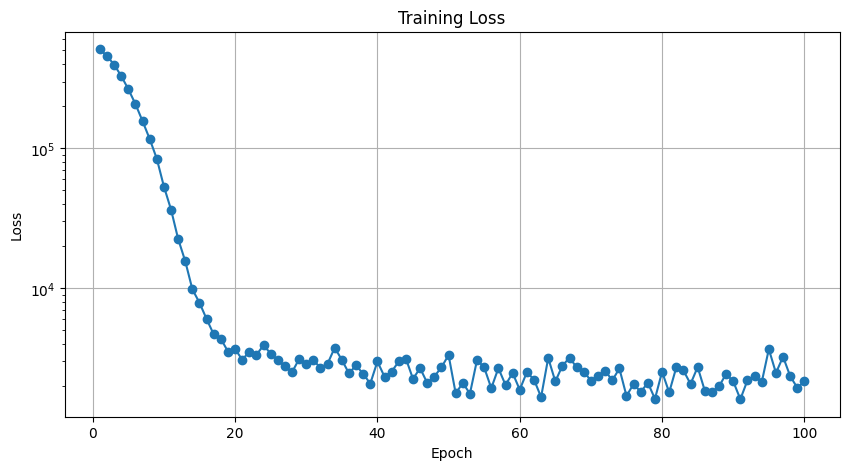

In [57]:
import matplotlib.pyplot as plt

# LOSS PLOT with log scale for y-axis
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # y-axis를 로그 스케일로 설정
plt.grid(True)
plt.show()